# Step 1. Loading and preparing data

In [249]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path

In [250]:
train_path = Path('data', 'twitter_training.csv')
test_path = Path('data', 'twitter_validation.csv')

In [251]:
cols = ["id", "source", "label", "text"]
train_df = pd.read_csv(train_path, names=cols, header=None)
test_df = pd.read_csv(test_path, names=cols, header=None)
df = pd.concat([train_df, test_df], ignore_index=True)
df = df[['text', 'label']]
df = df[df["label"] != "Irrelevant"]

In [252]:
import re

URL_RE  = re.compile(r"https?://\S+|www\.\S+")
USER_RE = re.compile(r"@\w+")
HASH_RE = re.compile(r"#")

def clean_tweet(t: str) -> str:
    if not isinstance(t, str):
        return ""  
    t = URL_RE.sub(" ", t)
    t = USER_RE.sub(" ", t)
    t = HASH_RE.sub("", t)
    t = re.sub(r"\s+", " ", t).strip()
    t = t.replace("@user", " ")
    t = t.replace("http", " ")
    return t

df["text"] = df["text"].apply(clean_tweet)
df.head(5)

,text,label
0,im getting on borderlands and i will murder yo...,Positive
1,I am coming to the borders and I will kill you...,Positive
2,im getting on borderlands and i will kill you ...,Positive
3,im coming on borderlands and i will murder you...,Positive
4,im getting on borderlands 2 and i will murder ...,Positive


In [253]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
test_df, val_df = train_test_split(test_df, )

# Step 2. Text preprocessingStep 2. Text preprocessing

In [254]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download NLTK resources (only first time)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words("english"))
negations = {'no','not','nor','never'}
stop_words = stop_words.difference(negations)

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /home/hacker/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/hacker/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/hacker/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/hacker/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [255]:
def preprocess_text(text):
    text = str(text).lower()
    tokens = word_tokenize(text)
    tokens = [
        word for word in tokens
        if word.isalpha() and word not in stop_words
    ]
    lemmas = [lemmatizer.lemmatize(word) for word in tokens]

    return " ".join(lemmas)

train_df['clean_text'] = train_df['text'].apply(preprocess_text)
test_df['clean_text'] = test_df['text'].apply(preprocess_text)
val_df['clean_text'] = val_df['text'].apply(preprocess_text)

# Step 3. Converting texts into vectors (VADER)

### TF-IDF

In [256]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [257]:
vectorizer = TfidfVectorizer(
    max_features=5000,     # limit to top 5000 words
    ngram_range=(1,2),     # include unigrams + bigrams
    min_df=2,              # ignore very rare words
)

X_train = vectorizer.fit_transform(train_df["clean_text"])
X_val   = vectorizer.transform(val_df["clean_text"])
X_test  = vectorizer.transform(test_df["clean_text"])

### Lexicon-based sentiment scores (VADER)
`VADER (Valence Aware Dictionary for Sentiment Reasoning) is perfect for social-media style text like tweets.`


In [258]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/hacker/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [259]:
def vader_score(text):
    # Returns compound score between -1 (negative) and +1 (positive)
    return sia.polarity_scores(str(text))["compound"]

for df in [train_df, val_df, test_df]:
    df["vader_score"] = df["clean_text"].apply(vader_score)

# Example
train_df[["clean_text", "vader_score", "label"]].head(10)

,clean_text,vader_score,label
52591,blame,-0.3400,Positive
37075,simulated phishing attack recipient clicked ne...,-0.6705,Positive
70514,lol miscommunication kill,-0.4404,Neutral
47318,michael caputo went home depot lamp combat lon...,-0.3400,Neutral
17275,lmao wtf,0.0258,Neutral
1475,look girl love borderland death like people ca...,0.3818,Negative
63011,fuck madden time game mode never work xbox one...,-0.4404,Negative
491,looking kitchen,0.0000,Neutral
24566,best,0.6369,Positive
28523,new apex game trash,0.0000,Negative


In [260]:
def classify_vader(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

for df in [train_df, val_df, test_df]:
    df["vader_pred"] = df["vader_score"].apply(classify_vader)

train_df[["clean_text", "vader_score", "vader_pred", "label"]].head(10)

,clean_text,vader_score,vader_pred,label
52591,blame,-0.3400,Negative,Positive
37075,simulated phishing attack recipient clicked ne...,-0.6705,Negative,Positive
70514,lol miscommunication kill,-0.4404,Negative,Neutral
47318,michael caputo went home depot lamp combat lon...,-0.3400,Negative,Neutral
17275,lmao wtf,0.0258,Neutral,Neutral
1475,look girl love borderland death like people ca...,0.3818,Positive,Negative
63011,fuck madden time game mode never work xbox one...,-0.4404,Negative,Negative
491,looking kitchen,0.0000,Neutral,Neutral
24566,best,0.6369,Positive,Positive
28523,new apex game trash,0.0000,Neutral,Negative


# Step 4. Model training

### Train a classifier (Logistic Regression and Naive Bayes).

In [261]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_train = train_df["label"]
y_val   = val_df["label"]
y_test  = test_df["label"]

In [262]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

y_val_pred_lr = log_reg.predict(X_val)

In [263]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

y_val_pred_nb = nb.predict(X_val)

# Step 5. Evaluation of quality

### Build a confusion matrix.

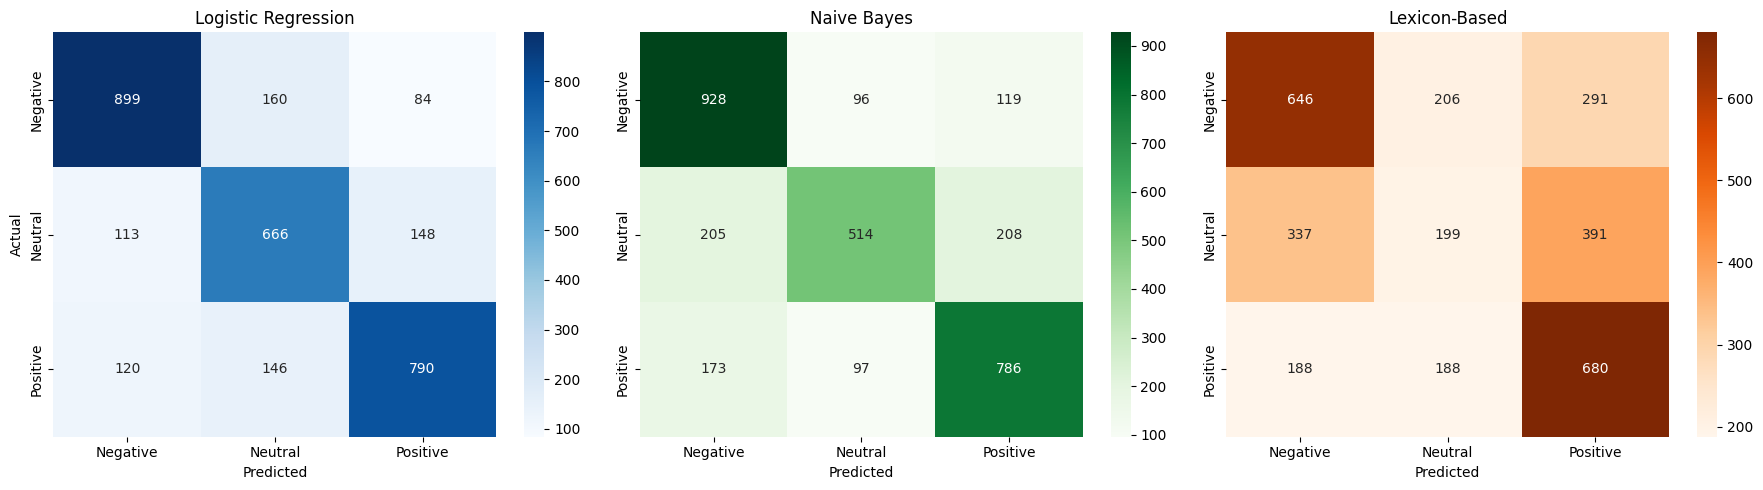

In [264]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- Logistic Regression ---
sns.heatmap(
    confusion_matrix(y_val, y_val_pred_lr),
    annot=True, fmt='d', cmap='Blues',
    xticklabels=log_reg.classes_, yticklabels=log_reg.classes_,
    ax=axes[0]
)
axes[0].set_title("Logistic Regression")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# --- Naive Bayes ---
sns.heatmap(
    confusion_matrix(y_val, y_val_pred_nb),
    annot=True, fmt='d', cmap='Greens',
    xticklabels=nb.classes_, yticklabels=nb.classes_,
    ax=axes[1]
)
axes[1].set_title("Naive Bayes")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("")

# --- Lexicon-Based ---
unique_classes = sorted(val_df['vader_pred'].unique())
sns.heatmap(
    confusion_matrix(y_val, val_df['vader_pred']),
    annot=True, fmt='d', cmap='Oranges',
    xticklabels=unique_classes, yticklabels=unique_classes,
    ax=axes[2]
)
axes[2].set_title("Lexicon-Based")
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

### Calculate the metrics: accuracy, F1-score.

In [265]:
results = {
    "Model": ["Logistic Regression", "Naive Bayes", "Lexicon-Based Approach"],
    "Accuracy": [
        accuracy_score(y_val, y_val_pred_lr),
        accuracy_score(y_val, y_val_pred_nb),
        accuracy_score(y_val, val_df['vader_pred'])
    ],
    "F1-score (macro)": [
        f1_score(y_val, y_val_pred_lr, average='macro'),
        f1_score(y_val, y_val_pred_nb, average='macro'),
        f1_score(y_val, val_df['vader_pred'], average='macro')
    ]
}

# Create DataFrame
results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,F1-score (macro)
0,Logistic Regression,0.753359,0.750699
1,Naive Bayes,0.712732,0.703916
2,Lexicon-Based Approach,0.487844,0.460877


# Step 6. Error analysis

In [266]:
# Create a comparison DataFrame
errors_lr = val_df.copy()
errors_lr["predicted"] = y_val_pred_lr
errors_lr["true"] = y_val

# Select only misclassified examples
errors_lr = errors_lr[errors_lr["predicted"] != errors_lr["true"]]

# Display some examples
errors_lr[["clean_text", "true", "predicted"]].head(10)


,clean_text,true,predicted
42297,become weak went friend house playing pubg tal...,Neutral,Positive
3283,cold war black ops zombie damn hype,Negative,Positive
67130,try recreate crap say one thing pity buy babe ...,Negative,Neutral
39101,crazy day hearthstone new card live show revea...,Positive,Neutral
20181,love everything earned not tumor achievement,Negative,Neutral
52989,skinned red dead redemption yesterday hour com...,Neutral,Positive
75582,iphone need hurry cause need get cause trash e...,Positive,Negative
23973,shoutout teacher going extra step connect stud...,Neutral,Positive
9763,strong netflix vibe like,Positive,Neutral
25967,oh shit,Positive,Negative


# Step 7. Visualization

### Word Clouds for Positive and Negative Reviews

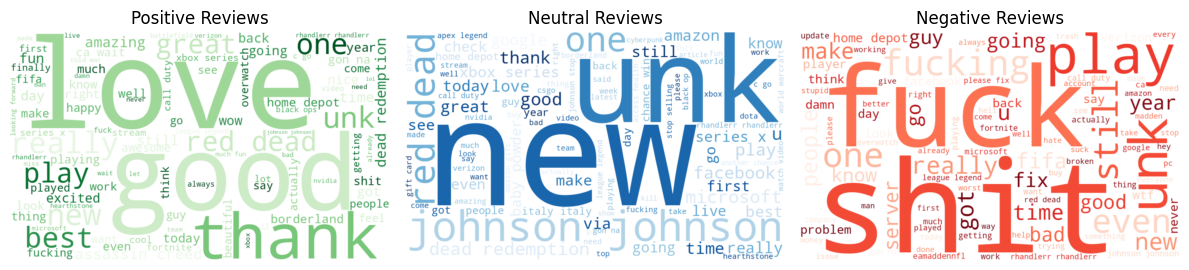

In [297]:
from wordcloud import WordCloud

# Separate positive and negative texts
positive_texts = " ".join(train_df[train_df["label"] == "Positive"]["clean_text"]).replace("game","")
negative_texts = " ".join(train_df[train_df["label"] == "Negative"]["clean_text"]).replace("game","")
neutral_texts = " ".join(train_df[train_df["label"] == "Neutral"]["clean_text"]).replace("game","")

# Generate word clouds
wc_positive = WordCloud(width=1000, height=600, background_color='white', colormap='Greens', max_words=100).generate(positive_texts)
wc_neutral = WordCloud(width=1000, height=600, background_color='white', colormap='Blues', max_words=100).generate(neutral_texts)
wc_negative = WordCloud(width=1000, height=600, background_color='white', colormap='Reds', max_words=100).generate(negative_texts)

# Display
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(wc_positive, interpolation='bilinear')
plt.axis("off")
plt.title("Positive Reviews")

plt.subplot(1,3,2)
plt.imshow(wc_neutral, interpolation='bilinear')
plt.axis("off")
plt.title("Neutral Reviews")

plt.subplot(1,3,3)
plt.imshow(wc_negative, interpolation='bilinear')
plt.axis("off")
plt.title("Negative Reviews")

plt.tight_layout()
plt.show()


### Top Important Words from Logistic Regression

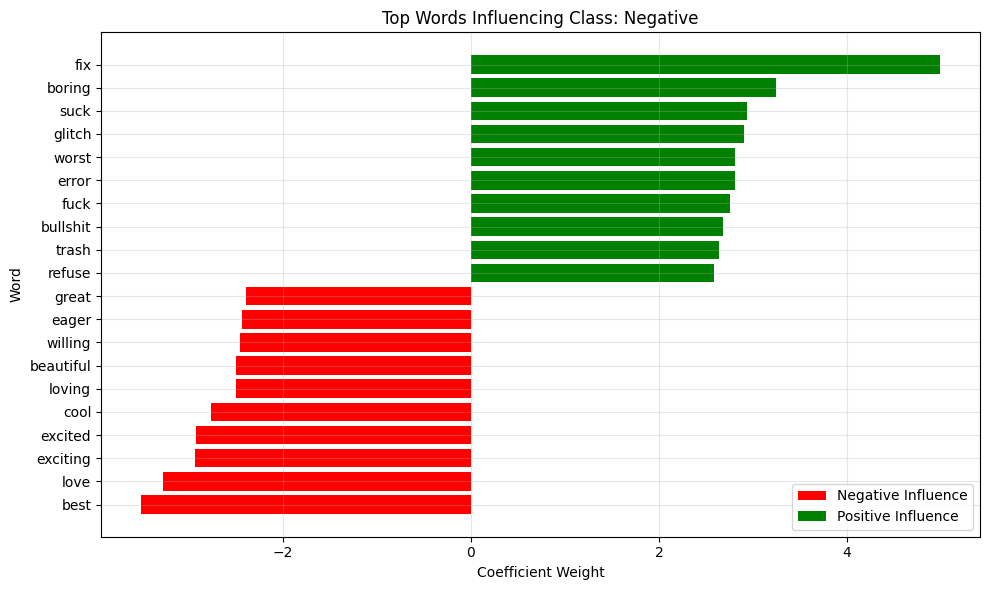

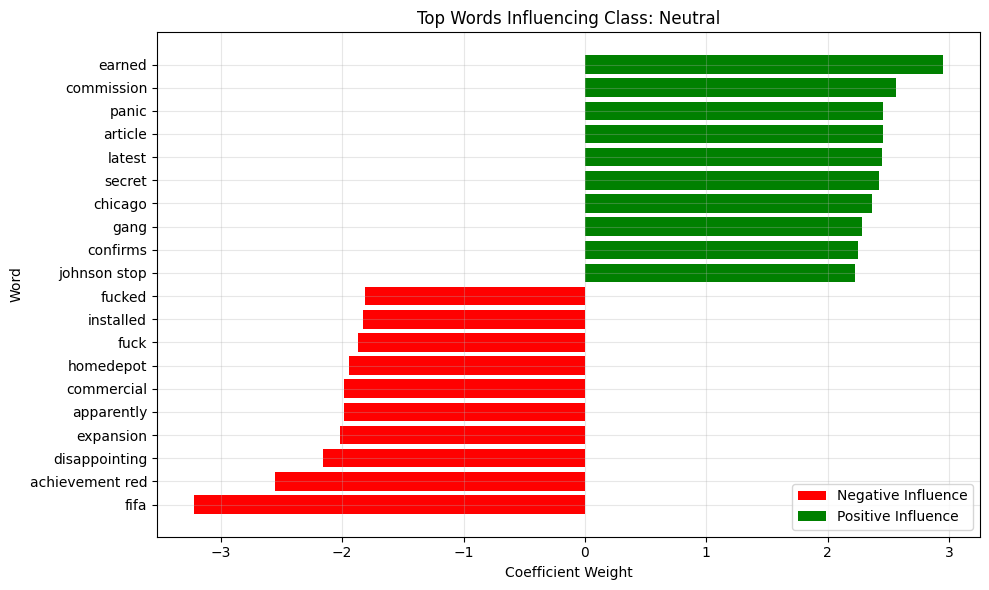

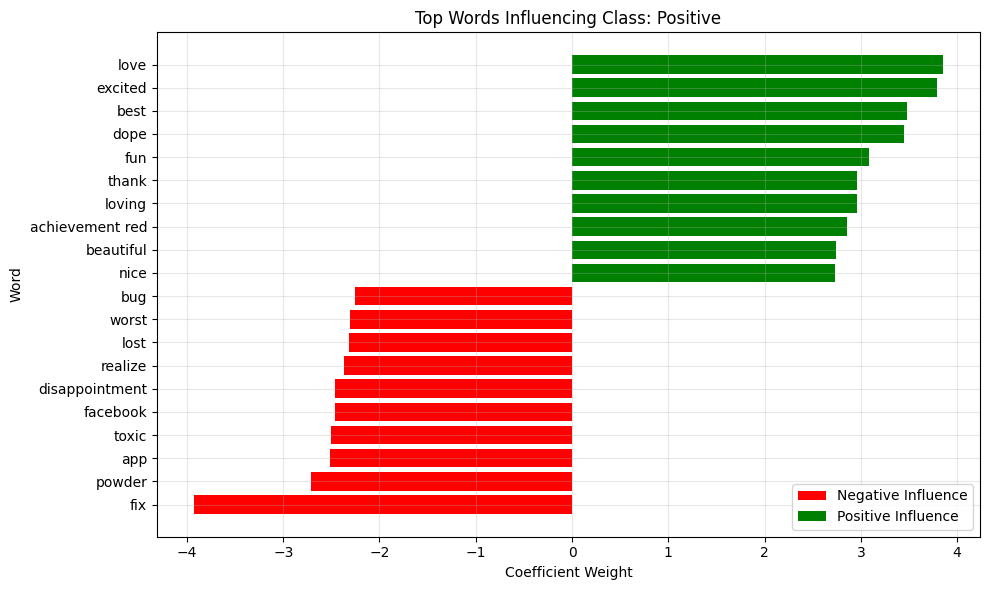

: 

In [ ]:
feature_names = np.array(vectorizer.get_feature_names_out())

# Iterate over classes in the logistic regression model
for i, label in enumerate(log_reg.classes_):
    coef = log_reg.coef_[i]

    # Top 10 positive and top 10 negative weights
    top10_idx = np.argsort(coef)[-10:]
    bottom10_idx = np.argsort(coef)[:10]

    top_words = feature_names[top10_idx]
    top_weights = coef[top10_idx]

    bottom_words = feature_names[bottom10_idx]
    bottom_weights = coef[bottom10_idx]

    # Combine both sets into one plot
    plt.figure(figsize=(10, 6))

    # Plot negative words (red)
    plt.barh(bottom_words, bottom_weights, color="red", label="Negative Influence")
    # Plot positive words (green)
    plt.barh(top_words, top_weights, color="green", label="Positive Influence")

    plt.title(f"Top Words Influencing Class: {label}")
    plt.xlabel("Coefficient Weight")
    plt.ylabel("Word")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()